(eigen)=
# 特征值和特征向量

```{index} single: Eigenvalues and Eigenvectors
```

## 概述

特征值和特征向量是线性代数中一个相对高级的话题。

同时，这些概念在以下领域非常有用：

* 经济建模（尤其是动态模型！）
* 统计学
* 应用数学的某些部分
* 机器学习
* 以及许多其他科学领域

在本讲座中，我们将解释特征值和特征向量的基础知识，并介绍诺伊曼级数引理。

我们假设学生已经熟悉矩阵，并理解{doc}`矩阵代数的基础知识<linear_equations>`。

我们将使用以下导入：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import matrix_power
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

(matrices_as_transformation)=
## 矩阵作为变换

让我们从讨论一个关于矩阵的重要概念开始。

### 将向量映射到向量

有两种思考矩阵的方式：
1. 将矩阵视为一个矩形的数字集合。
2. 将矩阵视为一个将向量转换为新向量的*映射*（即函数）。

为了理解第二种观点，假设我们将一个 $n \times m$ 矩阵 $A$ 与一个 $m \times 1$ 列向量 $x$ 相乘，得到一个 $n \times 1$ 列向量 $y$：

$$
    Ax = y
$$

如果我们固定 $A$ 并考虑不同的 $x$，我们可以将 $A$ 理解为一个将 $x$ 转换为 $Ax$ 的映射。

因为 $A$ 是 $n \times m$ 的，所以它将 $m$ 维向量转换为 $n$ 维向量。

我们可以正式地将此写作 $A \colon \mathbb{R}^m \rightarrow \mathbb{R}^n$。

你可能会说，如果 $A$ 是一个函数，那么我们应该写成 $A(x) = y$ 而不是 $Ax = y$，但后者的表示方法更为常见。

### 方阵

让我们将讨论限制在方阵上。

在上述讨论中，这意味着 $m=n$，则 $A$ 将 $\mathbb R^n$ 映射到自身。

这表示 $A$ 是一个 $n \times n$ 矩阵，它将 $\mathbb{R}^n$ 中的向量 $x$ 映射（或"变换"）为同样在 $\mathbb{R}^n$ 中的新向量 $y=Ax$。

以下是一个例子

```{prf:example}
:label: eigen1_ex_sq

$$
    \begin{bmatrix}
        2 & 1 \\
        -1 & 1
    \end{bmatrix}
    \begin{bmatrix}
        1 \\
        3
    \end{bmatrix}
    =
    \begin{bmatrix}
        5 \\
        2
    \end{bmatrix}
$$

在这里，矩阵

$$
    A = \begin{bmatrix} 2 & 1 \\ 
                        -1 & 1 
        \end{bmatrix}
$$

将向量 $x = \begin{bmatrix} 1 \\ 3 \end{bmatrix}$ 变换为向量 $y = \begin{bmatrix} 5 \\ 2 \end{bmatrix}$。
```

让我们用 Python 来可视化这个过程：

In [2]:
A = np.array([[2,  1],
              [-1, 1]])

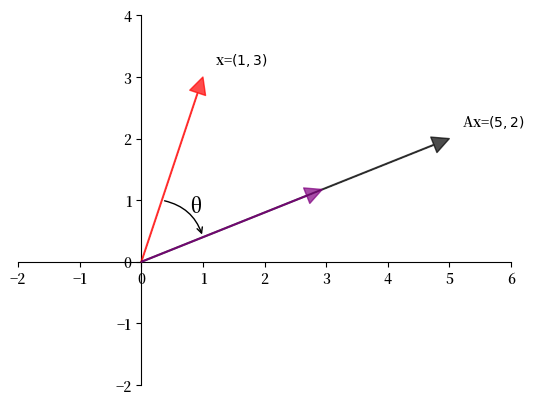

In [3]:
from math import sqrt

fig, ax = plt.subplots()
# 设置坐标轴通过原点

for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
for spine in ['right', 'top']:
    ax.spines[spine].set_color('none')

ax.set(xlim=(-2, 6), ylim=(-2, 4), aspect=1)

vecs = ((1, 3), (5, 2))
c = ['r', 'black']
for i, v in enumerate(vecs):
    ax.annotate('', xy=v, xytext=(0, 0),
                arrowprops=dict(color=c[i],
                shrink=0,
                alpha=0.7,
                width=0.5))

ax.text(0.2 + 1, 0.2 + 3, 'x=$(1,3)$')
ax.text(0.2 + 5, 0.2 + 2, 'Ax=$(5,2)$')

ax.annotate('', xy=(sqrt(10/29) * 5, sqrt(10/29) * 2), xytext=(0, 0),
            arrowprops=dict(color='purple',
                            shrink=0,
                            alpha=0.7,
                            width=0.5))

ax.annotate('', xy=(1, 2/5), xytext=(1/3, 1),
            arrowprops={'arrowstyle': '->',
                        'connectionstyle': 'arc3,rad=-0.3'},
            horizontalalignment='center')
ax.text(0.8, 0.8, f'θ', fontsize=14)

plt.show()

我们可以这样理解 $A$： 

* 首先将 $x$ 旋转某个角度 $\theta$，然后
* 将其缩放某个标量 $\gamma$ 以获得 $x$ 的像 $y$。

## 变换类型

让我们来检查一些可以用矩阵执行的标准变换。

下面我们通过将向量视为点而不是箭头来可视化变换。

我们将给定一个矩阵并观察它如何变换
* 一个点阵网格和
* 位于 $\mathbb{R}^2$ 中单位圆上的一组点。

为了构建这些变换，我们将使用两个函数，称为 `grid_transform` 和 `circle_transform`。

这些函数中的每一个都可视化一个特定的 $2 \times 2$ 矩阵 $A$ 的作用。

In [4]:
def colorizer(x, y):
    r = min(1, 1-y/3)
    g = min(1, 1+y/3)
    b = 1/4 + x/16
    return (r, g, b)


def grid_transform(A=np.array([[1, -1], [1, 1]])):
    xvals = np.linspace(-4, 4, 9)
    yvals = np.linspace(-3, 3, 7)
    xygrid = np.column_stack([[x, y] for x in xvals for y in yvals])
    uvgrid = A @ xygrid

    colors = list(map(colorizer, xygrid[0], xygrid[1]))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    for axes in ax:
        axes.set(xlim=(-11, 11), ylim=(-11, 11))
        axes.set_xticks([])
        axes.set_yticks([])
        for spine in ['left', 'bottom']:
            axes.spines[spine].set_position('zero')
        for spine in ['right', 'top']:
            axes.spines[spine].set_color('none')

    # 绘制x-y格点
    ax[0].scatter(xygrid[0], xygrid[1], s=36, c=colors, edgecolor="none")
    # ax[0].grid(True)
    # ax[0].axis("equal")
    ax[0].set_title(r"点 $x_1, x_2, \cdots, x_k$")

    # 绘制变换的格点
    ax[1].scatter(uvgrid[0], uvgrid[1], s=36, c=colors, edgecolor="none")
    # ax[1].grid(True)
    # ax[1].axis("equal")
    ax[1].set_title(r"点 $Ax_1, Ax_2, \cdots, Ax_k$")

    plt.show()


def circle_transform(A=np.array([[-1, 2], [0, 1]])):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    for axes in ax:
        axes.set(xlim=(-4, 4), ylim=(-4, 4))
        axes.set_xticks([])
        axes.set_yticks([])
        for spine in ['left', 'bottom']:
            axes.spines[spine].set_position('zero')
        for spine in ['right', 'top']:
            axes.spines[spine].set_color('none')

    θ = np.linspace(0, 2 * np.pi, 150)
    r = 1

    θ_1 = np.empty(12)
    for i in range(12):
        θ_1[i] = 2 * np.pi * (i/12)

    x = r * np.cos(θ)
    y = r * np.sin(θ)
    a = r * np.cos(θ_1)
    b = r * np.sin(θ_1)
    a_1 = a.reshape(1, -1)
    b_1 = b.reshape(1, -1)
    colors = list(map(colorizer, a, b))
    ax[0].plot(x, y, color='black', zorder=1)
    ax[0].scatter(a_1, b_1, c=colors, alpha=1, s=60,
                  edgecolors='black', zorder=2)
    ax[0].set_title(r"在 $\mathbb{R}^2$的单位圆")

    x1 = x.reshape(1, -1)
    y1 = y.reshape(1, -1)
    ab = np.concatenate((a_1, b_1), axis=0)
    transformed_ab = A @ ab
    transformed_circle_input = np.concatenate((x1, y1), axis=0)
    transformed_circle = A @ transformed_circle_input
    ax[1].plot(transformed_circle[0, :],
               transformed_circle[1, :], color='black', zorder=1)
    ax[1].scatter(transformed_ab[0, :], transformed_ab[1:,],
                  color=colors, alpha=1, s=60, edgecolors='black', zorder=2)
    ax[1].set_title("变换后的圆")

    plt.show()

### 缩放

类似

$$
    \begin{bmatrix} 
        \alpha & 0 
        \\ 0 & \beta 
    \end{bmatrix}
$$

的矩阵沿 x 轴将向量缩放 $\alpha$ 倍，沿 y 轴缩放 $\beta$ 倍。

这里我们举一个简单的例子，其中 $\alpha = \beta = 3$ 。

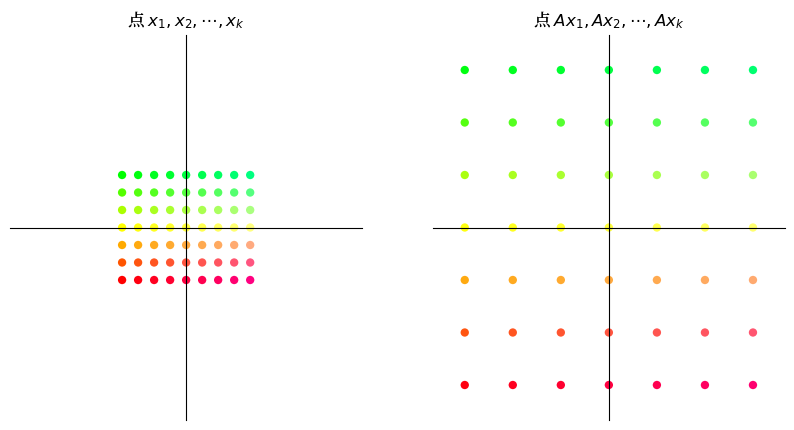

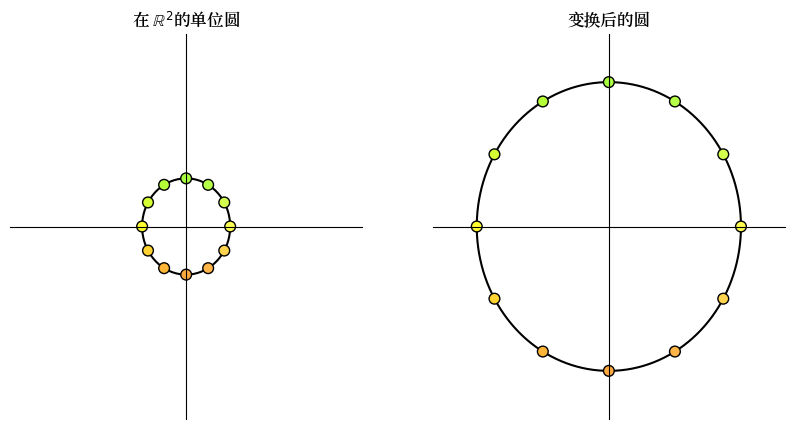

In [5]:
A = np.array([[3, 0],  # 在两个方向放大三倍
              [0, 3]])
grid_transform(A)
circle_transform(A)

### 剪切

类似

$$
    \begin{bmatrix} 
        1 & \lambda \\ 
        0 & 1 
    \end{bmatrix}
$$ 

的"剪切"矩阵沿 x 轴拉伸向量，拉伸量与点的 y 坐标成比例。

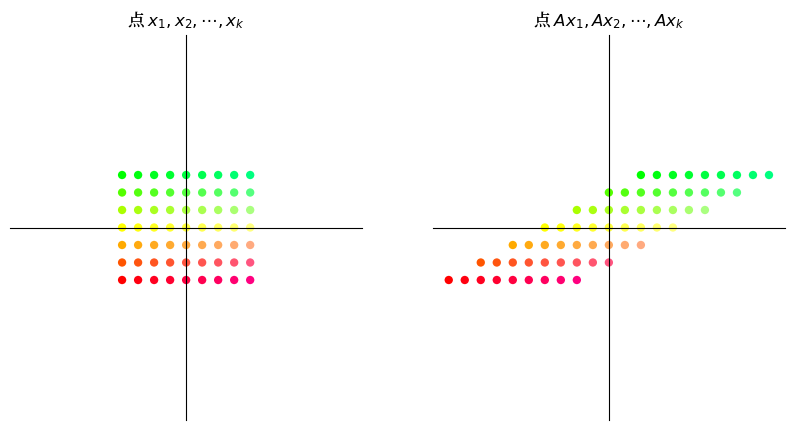

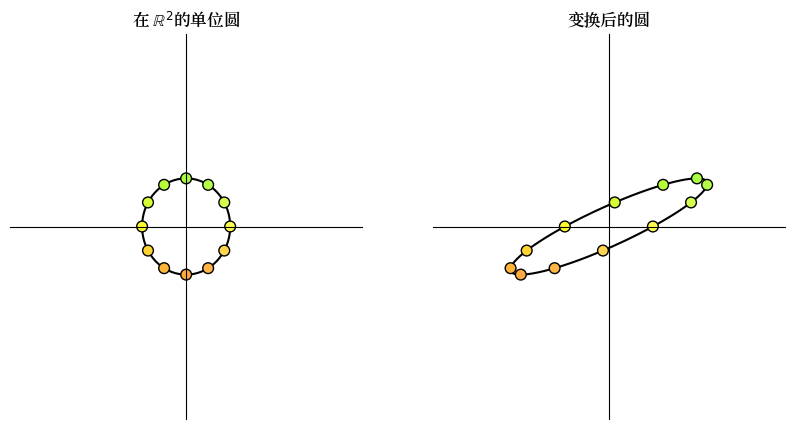

In [6]:
A = np.array([[1, 2],     # 沿x-轴进行剪切
              [0, 1]])
grid_transform(A)
circle_transform(A)

### 旋转

类似

$$
    \begin{bmatrix} 
        \cos \theta & \sin \theta 
        \\ - \sin \theta & \cos \theta 
    \end{bmatrix}
$$

的矩阵被称为 *旋转矩阵* 。

这个矩阵将向量顺时针旋转角度 $\theta$ 。

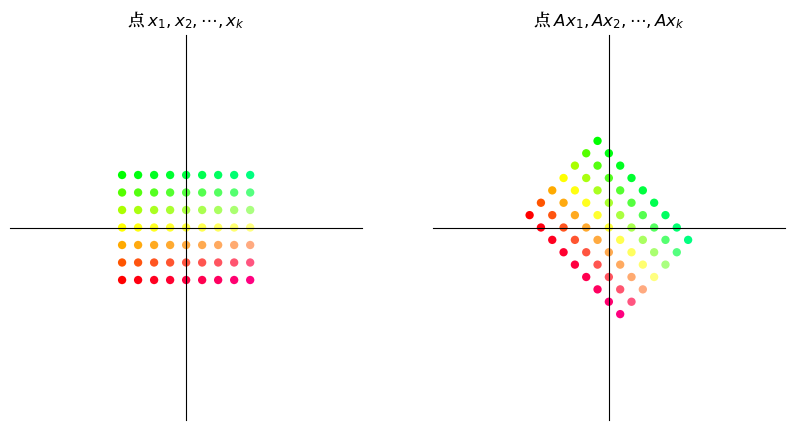

In [7]:
θ = np.pi/4  # 顺时针旋转45度
A = np.array([[np.cos(θ), np.sin(θ)],
              [-np.sin(θ), np.cos(θ)]])
grid_transform(A)

### 置换

置换矩阵

$$
    \begin{bmatrix} 
        0 & 1 \\ 
        1 & 0 
    \end{bmatrix}
$$ 

交换向量的坐标。

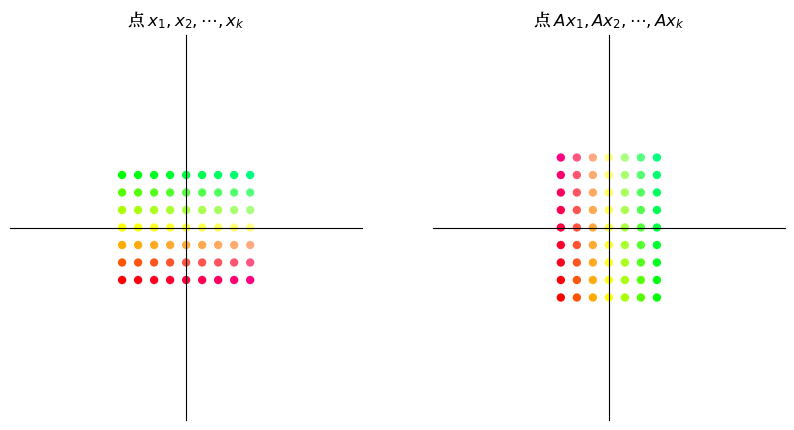

In [8]:
A = np.column_stack([[0, 1], [1, 0]])
grid_transform(A)

更多常见的变换矩阵示例可以在[这里](https://baike.baidu.com/item/%E5%8F%98%E6%8D%A2%E7%9F%A9%E9%98%B5/9035701)找到。

## 矩阵乘法作为组合

由于矩阵可以理解为将一个向量转换为另一个向量的函数，我们也可以将函数组合的概念应用于矩阵。

### 线性组合

考虑两个矩阵

$$
    A = 
        \begin{bmatrix} 
            0 & 1 \\ 
            -1 & 0 
        \end{bmatrix}
        \quad \text{和} \quad
    B = 
        \begin{bmatrix} 
            1 & 2 \\ 
            0 & 1 
        \end{bmatrix}
$$ 

当我们尝试对某个 $2 \times 1$ 向量 $x$ 求 $ABx$ 时，输出会是什么？

$$
\color{red}{\underbrace{
 \color{black}{\begin{bmatrix}
  0 & 1 \\
 -1 & 0
 \end{bmatrix}}
}_{\textstyle A} }
\color{red}{\underbrace{
 \color{black}{\begin{bmatrix}
  1 & 2 \\
  0 & 1
 \end{bmatrix}}
}_{\textstyle B}}
\color{red}{\overbrace{
 \color{black}{\begin{bmatrix}
  1 \\
  3
 \end{bmatrix}}
}^{\textstyle x}}
\rightarrow
\color{red}{\underbrace{
 \color{black}{\begin{bmatrix}
  0 & 1 \\
  -1 & -2
 \end{bmatrix}}
}_{\textstyle AB}}
\color{red}{\overbrace{
 \color{black}{\begin{bmatrix}
  1 \\
  3
 \end{bmatrix}}
}^{\textstyle x}}
\rightarrow
\color{red}{\overbrace{
 \color{black}{\begin{bmatrix}
  3 \\
  -7
 \end{bmatrix}}
}^{\textstyle y}}
$$

$$
\color{red}{\underbrace{
 \color{black}{\begin{bmatrix}
  0 & 1 \\
 -1 & 0
 \end{bmatrix}}
}_{\textstyle A} }
\color{red}{\underbrace{
 \color{black}{\begin{bmatrix}
  1 & 2 \\
  0 & 1
 \end{bmatrix}}
}_{\textstyle B}}
\color{red}{\overbrace{
 \color{black}{\begin{bmatrix}
  1 \\
  3
 \end{bmatrix}}
}^{\textstyle x}}
\rightarrow
\color{red}{\underbrace{
 \color{black}{\begin{bmatrix}
  0 & 1 \\
  -1 & 0
 \end{bmatrix}}
}_{\textstyle A}}
\color{red}{\overbrace{
 \color{black}{\begin{bmatrix}
  7 \\
  3
 \end{bmatrix}}
}^{\textstyle Bx}}
\rightarrow
\color{red}{\overbrace{
 \color{black}{\begin{bmatrix}
  3 \\
  -7
 \end{bmatrix}}
}^{\textstyle y}}
$$

我们可以观察到，对向量 $x$ 应用变换 $AB$ 与先对 $x$ 应用 $B$，然后对向量 $Bx$ 应用 $A$ 是相同的。

因此，矩阵乘积 $AB$ 是矩阵变换 $A$ 和 $B$ 的[复合函数](https://baike.baidu.com/item/%E5%A4%8D%E5%90%88%E5%87%BD%E6%95%B0/6176286)。
这意味着先应用变换 $B$，然后应用变换 $A$。

当我们将一个 $n \times m$ 矩阵 $A$ 与一个 $m \times k$ 矩阵 $B$ 相乘时，得到的矩阵乘积是一个 $n \times k$ 矩阵 $AB$。

因此，如果 $A$ 和 $B$ 是变换， $A \colon \mathbb{R}^m \to \mathbb{R}^n$ 且 $B \colon \mathbb{R}^k \to \mathbb{R}^m$，那么 $AB$ 将 $\mathbb{R}^k$ 变换到 $\mathbb{R}^n$。

将矩阵乘法视为映射的组合有助于我们理解为什么在矩阵乘法下，$AB$ 通常不等于 $BA$。

（毕竟，当我们使用复合函数时，顺序通常很重要。）

### 示例

设 $A$ 为顺时针旋转 $90^{\circ}$ 的矩阵，即 $\begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}$ ，设 $B$ 为沿 x 轴的剪切矩阵，即 $\begin{bmatrix} 1 & 2 \\ 0 & 1 \end{bmatrix}$。

我们将可视化当我们应用变换 $AB$ 时点的网格如何变化，然后将其与变换 $BA$ 进行比较。

In [9]:
def grid_composition_transform(A=np.array([[1, -1], [1, 1]]),
                               B=np.array([[1, -1], [1, 1]])):
    xvals = np.linspace(-4, 4, 9)
    yvals = np.linspace(-3, 3, 7)
    xygrid = np.column_stack([[x, y] for x in xvals for y in yvals])
    uvgrid = B @ xygrid
    abgrid = A @ uvgrid

    colors = list(map(colorizer, xygrid[0], xygrid[1]))

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for axes in ax:
        axes.set(xlim=(-12, 12), ylim=(-12, 12))
        axes.set_xticks([])
        axes.set_yticks([])
        for spine in ['left', 'bottom']:
            axes.spines[spine].set_position('zero')
        for spine in ['right', 'top']:
            axes.spines[spine].set_color('none')

    # 绘制格点
    ax[0].scatter(xygrid[0], xygrid[1], s=36, c=colors, edgecolor="none")
    ax[0].set_title(r"点 $x_1, x_2, \cdots, x_k$")

    # 绘制中间的格点
    ax[1].scatter(uvgrid[0], uvgrid[1], s=36, c=colors, edgecolor="none")
    ax[1].set_title(r"点 $Bx_1, Bx_2, \cdots, Bx_k$")

    # 绘制变换后的格点
    ax[2].scatter(abgrid[0], abgrid[1], s=36, c=colors, edgecolor="none")
    ax[2].set_title(r"点 $ABx_1, ABx_2, \cdots, ABx_k$")

    plt.show()

In [10]:
A = np.array([[0, 1],     # 顺时针旋转90度
              [-1, 0]])
B = np.array([[1, 2],     # 沿x-轴剪切
              [0, 1]])

#### 剪切后旋转

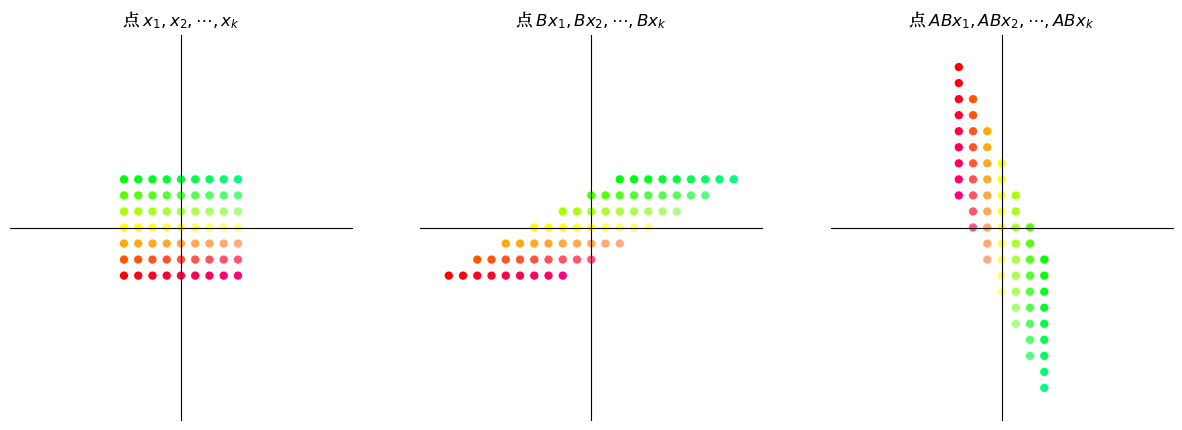

In [11]:
grid_composition_transform(A, B)  # 变换 AB

#### 旋转后剪切

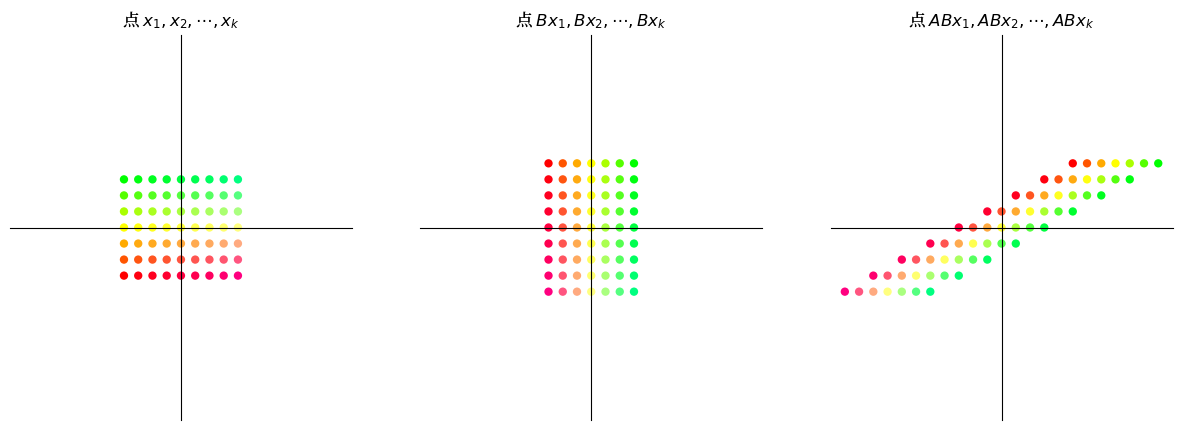

In [12]:
grid_composition_transform(B, A)         # 变换 BA

很显然，变换 $AB$ 与变换 $BA$ 是不同的。

## 对固定映射进行迭代

在经济学（尤其是动态建模）中，我们经常对重复应用固定矩阵所产生的变换感兴趣。

例如，给定一个向量 $v$ 和一个矩阵 $A$，我们希望可以研究以下序列：

$$ 
    v, \quad
    Av, \quad
    AAv = A^2v, \quad \ldots
$$

让我们首先看一下在不同映射 $A$ 下的迭代序列 $(A^k v)_{k \geq 0}$ 的例子。

(plot_series)=

In [13]:
def plot_series(A, v, n):

    B = np.array([[1, -1],
                  [1, 0]])

    fig, ax = plt.subplots()

    ax.set(xlim=(-4, 4), ylim=(-4, 4))
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_position('zero')
    for spine in ['right', 'top']:
        ax.spines[spine].set_color('none')

    θ = np.linspace(0, 2 * np.pi, 150)
    r = 2.5
    x = r * np.cos(θ)
    y = r * np.sin(θ)
    x1 = x.reshape(1, -1)
    y1 = y.reshape(1, -1)
    xy = np.concatenate((x1, y1), axis=0)

    ellipse = B @ xy
    ax.plot(ellipse[0, :], ellipse[1, :], color='black',
            linestyle=(0, (5, 10)), linewidth=0.5)

    #初始化轨迹容器
    colors = plt.cm.rainbow(np.linspace(0, 1, 20))

    for i in range(n):
        iteration = matrix_power(A, i) @ v
        v1 = iteration[0]
        v2 = iteration[1]
        ax.scatter(v1, v2, color=colors[i])
        if i == 0:
            ax.text(v1+0.25, v2, f'$v$')
        elif i == 1:
            ax.text(v1+0.25, v2, f'$Av$')
        elif 1 < i < 4:
            ax.text(v1+0.25, v2, f'$A^{i}v$')
    plt.show()

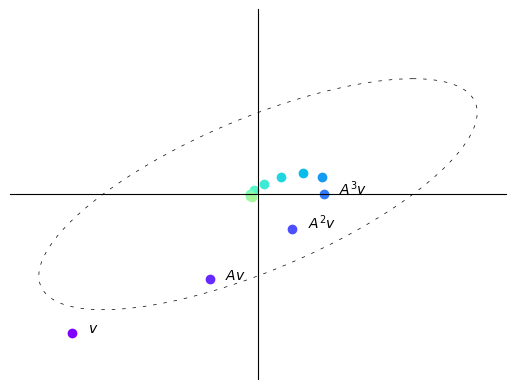

In [14]:
A = np.array([[sqrt(3) + 1, -2],
              [1, sqrt(3) - 1]])
A = (1/(2*sqrt(2))) * A
v = (-3, -3)
n = 12

plot_series(A, v, n)

每次迭代后，向量变得更短，即更靠近原点。

在这种情况下，重复将向量乘以$A$会使向量"螺旋式地向内"。

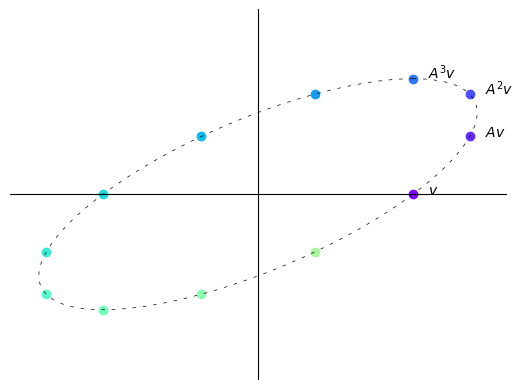

In [15]:
B = np.array([[sqrt(3) + 1, -2],
              [1, sqrt(3) - 1]])
B = (1/2) * B
v = (2.5, 0)
n = 12

plot_series(B, v, n)

在这里，每次迭代向量不会变长或变短。

在这种情况下，重复将向量乘以$A$只会使其"围绕一个椭圆旋转"。

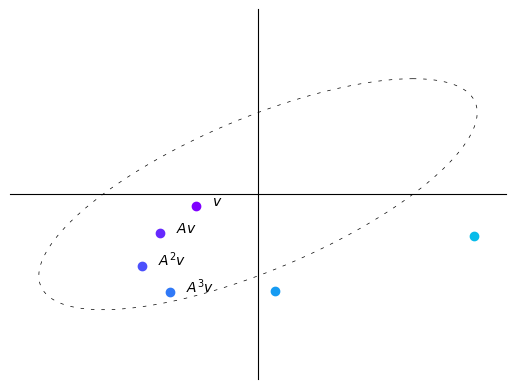

In [16]:
B = np.array([[sqrt(3) + 1, -2],
              [1, sqrt(3) - 1]])
B = (1/sqrt(2)) * B
v = (-1, -0.25)
n = 6

plot_series(B, v, n)

在这里，每次迭代向量趋向于变长，即离原点更远。

在这种情况下，重复将向量乘以$A$会使向量"螺旋式地向外"。

因此，我们观察到序列$(A^kv)_{k \geq 0}$的行为取决于映射$A$本身。

现在我们讨论决定这种行为的$A$的性质。


(la_eigenvalues)=

## 特征值

```{index} single: Linear Algebra; Eigenvalues
```
在本节中，我们引入特征值和特征向量的概念。

### 定义

设 $A$ 为 $n \times n$ 的方阵。

如果存在标量 $\lambda$ 和非零 $n$ 维向量 $v$ ，使得

$$
A v = \lambda v.
$$

则我们称 $\lambda$ 为 $A$的 *特征值* ，$v$ 为相应的 *特征向量*。

因此，$A$ 的特征向量是一个非零向量 $v$，当映射 $A$ 应用于它时，$v$ 仅仅是被缩放。

下图显示了两个特征向量（蓝色箭头）及其在 $A$ 下的像（红色箭头）。

如预期的那样，每个 $v$ 的像 $Av$ 只是原始向量的缩放。

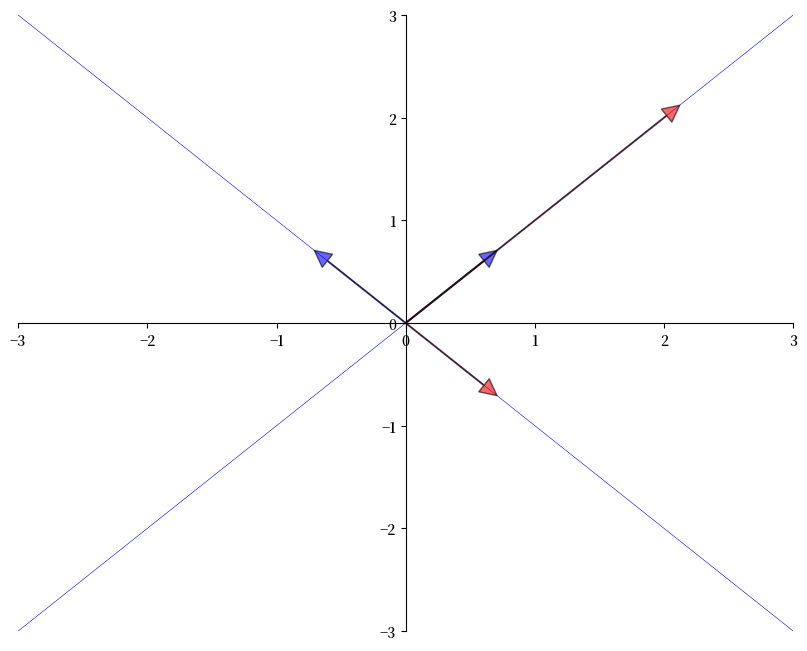

In [17]:
from numpy.linalg import eig

A = [[1, 2],
     [2, 1]]
A = np.array(A)
evals, evecs = eig(A)
evecs = evecs[:, 0], evecs[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
# 将坐标轴设置为通过原点
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
for spine in ['right', 'top']:
    ax.spines[spine].set_color('none')
# ax.grid(alpha=0.4)

xmin, xmax = -3, 3
ymin, ymax = -3, 3
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

# 绘制每个特征向量
for v in evecs:
    ax.annotate('', xy=v, xytext=(0, 0),
                arrowprops=dict(facecolor='blue',
                shrink=0,
                alpha=0.6,
                width=0.5))

# 绘制每个特征向量
for v in evecs:
    v = A @ v
    ax.annotate('', xy=v, xytext=(0, 0),
                arrowprops=dict(facecolor='red',
                shrink=0,
                alpha=0.6,
                width=0.5))

# 绘制它们经过的直线
x = np.linspace(xmin, xmax, 3)
for v in evecs:
    a = v[1] / v[0]
    ax.plot(x, a * x, 'b-', lw=0.4)

plt.show()

### 复数值

到目前为止，我们对特征值和特征向量的定义似乎很直观。

但还有一个我们尚未提到的复杂情况：

在求解 $Av = \lambda v$ 时，

* $\lambda$ 可以是复数，并且
* $v$ 可以是一个包含 n 个复数的向量。

我们将在下面看到一些例子。

### 一些数学细节

我们为有兴趣的读者注明一些数学细节。（其他读者可以跳到下一节。）

特征值方程等价于 $(A - \lambda I) v = 0$。

只有当 $A - \lambda I$ 的列线性相关时，这个方程才有非零解 $v$。

这反过来等价于行列式为零。

因此，要找到所有特征值，我们可以寻找使 $A - \lambda I$ 的行列式为零的 $\lambda$。

这个问题可以表示为求解一个 $\lambda$ 的 n 次多项式的根。

这进而意味着在复平面上存在 n 个解，尽管有些可能是重复的。

### 事实

关于方阵 $A$ 的特征值，有一些很好的事实：

1. $A$ 的行列式等于其特征值的乘积

2. $A$ 的迹（主对角线上元素的和）等于其特征值的和

3. 如果 $A$ 是对称的，那么它的所有特征值都是实数

4. 如果 $A$ 可逆，且 $\lambda_1, \ldots, \lambda_n$ 是它的特征值，那么 $A^{-1}$ 的特征值是 $1/\lambda_1, \ldots, 1/\lambda_n$。

最后一个陈述的一个推论是，当且仅当矩阵的所有特征值都非零时，该矩阵才是可逆的。

### 计算

使用 NumPy，我们可以按如下方式求解矩阵的特征值和特征向量

In [18]:
from numpy.linalg import eig

A = ((1, 2),
     (2, 1))

A = np.array(A)
evals, evecs = eig(A)
evals  # 特征值

array([ 3., -1.])

In [19]:
evecs  # 特征向量

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

请注意，`evecs` 的*列*是特征向量。

由于特征向量的任何标量倍数都是具有相同特征值的特征向量（可以试着验证一下），`eig` 程序将每个特征向量的长度归一化为1。

映射 $A$ 的特征向量和特征值决定了当我们反复乘以 $A$ 时，向量 $v$ 如何被变换。

这一点将在后面进一步讨论。

(la_neumann)=
## 诺伊曼级数引理

```{index} single: Neumann's Lemma
```

在本节中，我们将介绍一个关于矩阵级数的著名结果，它在经济学中有许多应用。

### 标量级数

以下是关于级数的一个基本结果：

如果 $a$ 是一个数，且 $|a| < 1$，那么

```{math}
:label: gp_sum

    \sum_{k=0}^{\infty} a^k =\frac{1}{1-a} = (1 - a)^{-1}

```

对于一维线性方程 $x = ax + b$，其中 x 未知，我们可以得出解 $x^{*}$ 由以下给出：

$$
    x^{*} = \frac{b}{1-a} = \sum_{k=0}^{\infty} a^k b
$$

### 矩阵级数

这个想法在矩阵设置中也有一个推广。

考虑方程组 $x = Ax + b$，其中 $A$ 是一个 $n \times n$ 的方阵，$x$ 和 $b$ 都是 $\mathbb{R}^n$ 中的列向量。

使用矩阵代数，我们可以得出这个方程组的解由以下给出：


```{math}
:label: neumann_eqn

    x^{*} = (I-A)^{-1}b
    
```

什么条件保证了存在唯一的向量 $x^{*}$ 满足方程 {eq}`neumann_eqn`？

以下是泛函分析中的一个基本结果，它将 {eq}`gp_sum` 推广到多变量情况。

(neumann_series_lemma)=
```{prf:Theorem} 诺伊曼级数引理
:label: neumann_series_lemma

设 $A$ 为方阵，$A^k$ 为 $A$ 的 $k$ 次幂。
设 $r(A)$ 为 $A$ 的**谱半径**，定义为 $\max_i |\lambda_i|$，其中
* $\{\lambda_i\}_i$ 是 $A$ 的特征值集，且
* $|\lambda_i|$ 是复数 $\lambda_i$ 的模

诺伊曼定理陈述如下：如果 $r(A) < 1$，那么 $I - A$ 是可逆的，且

$$
(I - A)^{-1} = \sum_{k=0}^{\infty} A^k
$$
```

我们可以在以下例子中看到诺伊曼级数引理的应用。

In [20]:
A = np.array([[0.4, 0.1],
              [0.7, 0.2]])

evals, evecs = eig(A)   #求出特征值和特征向量

r = max(abs(λ) for λ in evals)    # 计算谱半径
print(r)

0.5828427124746189


获得的谱半径 $r(A)$ 小于1。

因此，我们可以应用诺伊曼级数引理来求 $(I-A)^{-1}$。

In [21]:
I = np.identity(2)  # 2 x 2 单位矩阵
B = I - A

In [22]:
B_inverse = np.linalg.inv(B)  # 直接求逆

In [23]:
A_sum = np.zeros((2, 2))  # A 的幂级数和
A_power = I
for i in range(50):
    A_sum += A_power
    A_power = A_power @ A

让我们检查求和方法和逆序方法的结果是否相等。

In [24]:
np.allclose(A_sum, B_inverse)

True

虽然我们在 $k = 50$ 时截断了无限级数，但两种方法给出了相同的结果，这体现了诺伊曼级数引理的结论。

## 练习

```{exercise}
:label: eig1_ex1

幂迭代法是一种用于寻找可对角化矩阵最大绝对特征值的方法。

该方法从一个随机向量 $b_0$ 开始，重复地对其应用矩阵 $A$

$$
b_{k+1}=\frac{A b_k}{\left\|A b_k\right\|}
$$

关于该方法的详细讨论可以在[这里](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter15.02-The-Power-Method.html)找到。

在这个练习中，首先实现幂迭代方法，并用它来找出最大绝对特征值及其对应的特征向量。

然后可视化收敛过程。
```

```{solution-start} eig1_ex1
:class: dropdown
```

这里有一个解决方案。

我们首先研究特征向量近似值与真实特征向量之间的距离。

近似的最大绝对特征值是         4.00
真实的特征值是 [ 4. -2.  2.]


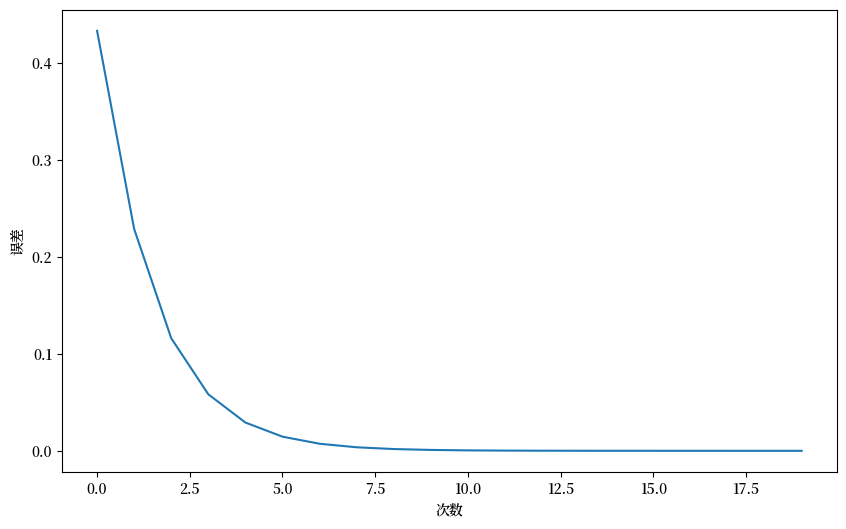

In [25]:
# 定义矩阵A
A = np.array([[1, 0, 3],
              [0, 2, 0],
              [3, 0, 1]])

num_iters = 20

# 定义一个随机的初始向量 b
b = np.random.rand(A.shape[1])

# 获取矩阵A的主特征向量
eigenvector = np.linalg.eig(A)[1][:, 0]

errors = []
res = []

# 幂迭代循环
for i in range(num_iters):
    # Multiply b by A
    b = A @ b
    # 归一化b
    b = b / np.linalg.norm(b)
    # 将b添加到特征向量近似值列表中
    res.append(b)
    err = np.linalg.norm(np.array(b)
                         - eigenvector)
    errors.append(err)

greatest_eigenvalue = np.dot(A @ b, b) / np.dot(b, b)
print(f'近似的最大绝对特征值是 \
        {greatest_eigenvalue:.2f}')
print('真实的特征值是', np.linalg.eig(A)[0])

# 绘制每次迭代的特征向量近似值
plt.figure(figsize=(10, 6))
plt.xlabel('次数')
plt.ylabel('误差')
_ = plt.plot(errors)

然后我们可以观察特征向量近似值的轨迹。

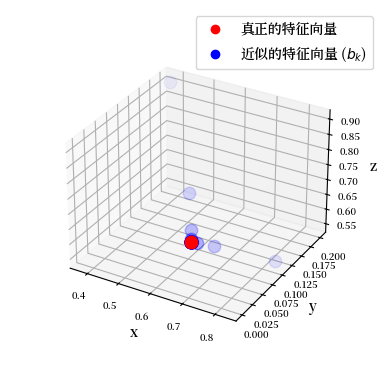

In [26]:
# 设置3D图形和坐标轴
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制特征向量
ax.scatter(eigenvector[0],
           eigenvector[1],
           eigenvector[2],
           color='r', s=80)

for i, vec in enumerate(res):
    ax.scatter(vec[0], vec[1], vec[2],
               color='b',
               alpha=(i+1)/(num_iters+1),
               s=80)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.tick_params(axis='both', which='major', labelsize=7)

points = [plt.Line2D([0], [0], linestyle='none',
                     c=i, marker='o') for i in ['r', 'b']]
ax.legend(points, ['真正的特征向量',
                   r'近似的特征向量 ($b_k$)'])
ax.set_box_aspect(aspect=None, zoom=0.8)

plt.show()

```{solution-end}
```

```{exercise}
:label: eig1_ex2

我们已经讨论了向量 $v$ 经过矩阵 $A$ 变换后的轨迹。

考虑矩阵 $A = \begin{bmatrix} 1 & 2 \\ 1 & 1 \end{bmatrix}$ 和向量 $v = \begin{bmatrix} 2 \\ -2 \end{bmatrix}$。

尝试计算向量 $v$ 经过矩阵 $A$ 变换 $n=4$ 次迭代后的轨迹，并绘制结果。

```

```{solution-start} eig1_ex2
:class: dropdown
```

特征值:
 [ 2.41421356 -0.41421356]
特征向量:
 [[ 0.81649658 -0.81649658]
 [ 0.57735027  0.57735027]]


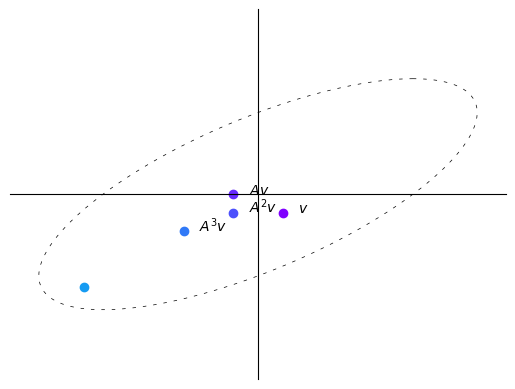

In [27]:
A = np.array([[1, 2],
              [1, 1]])
v = (0.4, -0.4)
n = 11

# 计算特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eig(A)

print(f'特征值:\n {eigenvalues}')
print(f'特征向量:\n {eigenvectors}')

plot_series(A, v, n)

结果似乎收敛于矩阵 $A$ 最大特征值对应的特征向量。

让我们使用[向量场](https://baike.baidu.com/item/%E5%90%91%E9%87%8F%E5%9C%BA/9812041)来可视化矩阵 $A$ 带来的变换。
（这是线性代数中的一个较高级话题，如果你对数学感到足够自信和感兴趣的话，可以继续往下学习。）

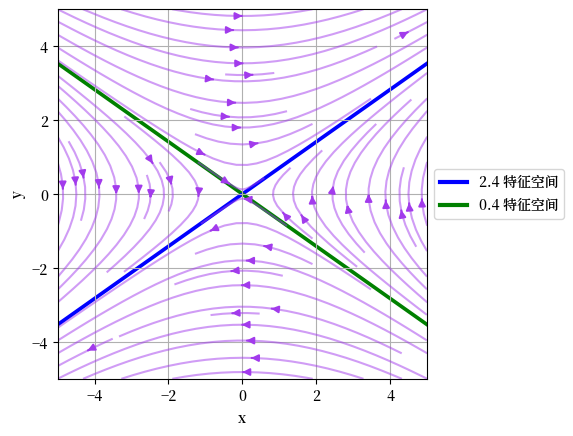

In [28]:
# 创建格点
x, y = np.meshgrid(np.linspace(-5, 5, 15),
                   np.linspace(-5, 5, 20))

#将矩阵A应用于向量场中的每个点
vec_field = np.stack([x, y])
u, v = np.tensordot(A, vec_field, axes=1)

# 绘制转换后的向量场
c = plt.streamplot(x, y, u - x, v - y,
                   density=1, linewidth=None, color='#A23BEC')
c.lines.set_alpha(0.5)
c.arrows.set_alpha(0.5)

# 绘制特征向量
origin = np.zeros((2, len(eigenvectors)))
parameters = {'color': ['b', 'g'], 'angles': 'xy',
              'scale_units': 'xy', 'scale': 0.1, 'width': 0.01}
plt.quiver(*origin, eigenvectors[0],
           eigenvectors[1], **parameters)
plt.quiver(*origin, - eigenvectors[0],
           - eigenvectors[1], **parameters)

colors = ['b', 'g']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = ["2.4 特征空间", "0.4 特征空间"]
plt.legend(lines, labels, loc='center left',
           bbox_to_anchor=(1, 0.5))

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

请注意，向量场收敛于$A$的最大特征值对应的特征向量，并从$A$的最小特征值对应的特征向量发散。

实际上，特征向量也是矩阵$A$拉伸或压缩空间的方向。

具体来说，最大特征值对应的特征向量是矩阵$A$最大程度拉伸空间的方向。

我们将在接下来的练习中看到更多有趣的例子。

```{solution-end}
```

```{exercise}
:label: eig1_ex3

{ref}`之前 <plot_series>`，我们展示了向量$v$被三种不同矩阵$A$变换后的轨迹。

使用前面练习中的可视化来解释向量$v$被这三种不同矩阵$A$变换后的轨迹。

```


```{solution-start} eig1_ex3
:class: dropdown
```

以下是其中一种解法。

实例 1:

特征值:
 [0.61237244+0.35355339j 0.61237244-0.35355339j]
特征向量:
 [[0.81649658+0.j         0.81649658-0.j        ]
 [0.40824829-0.40824829j 0.40824829+0.40824829j]]



实例 2:

特征值:
 [0.8660254+0.5j 0.8660254-0.5j]
特征向量:
 [[0.81649658+0.j         0.81649658-0.j        ]
 [0.40824829-0.40824829j 0.40824829+0.40824829j]]



实例 3:

特征值:
 [1.22474487+0.70710678j 1.22474487-0.70710678j]
特征向量:
 [[0.81649658+0.j         0.81649658-0.j        ]
 [0.40824829-0.40824829j 0.40824829+0.40824829j]]



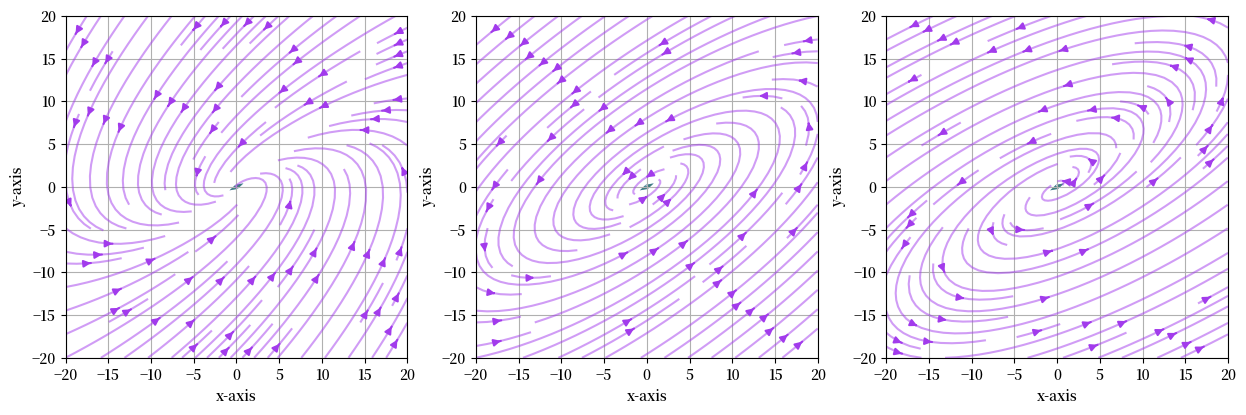

In [29]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
A = np.array([[sqrt(3) + 1, -2],
              [1, sqrt(3) - 1]])
A = (1/(2*sqrt(2))) * A

B = np.array([[sqrt(3) + 1, -2],
              [1, sqrt(3) - 1]])
B = (1/2) * B

C = np.array([[sqrt(3) + 1, -2],
              [1, sqrt(3) - 1]])
C = (1/sqrt(2)) * C

examples = [A, B, C]

for i, example in enumerate(examples):
    M = example

    # 计算特征向量和特征值
    eigenvalues, eigenvectors = np.linalg.eig(M)
    print(f'实例 {i+1}:\n')
    print(f'特征值:\n {eigenvalues}')
    print(f'特征向量:\n {eigenvectors}\n')

    eigenvalues_real = eigenvalues.real
    eigenvectors_real = eigenvectors.real

    # 创建格点
    x, y = np.meshgrid(np.linspace(-20, 20, 15),
                       np.linspace(-20, 20, 20))

    # 将矩阵A应用于向量场中的每个点
    vec_field = np.stack([x, y])
    u, v = np.tensordot(M, vec_field, axes=1)

    # 绘制转换后的向量场
    c = ax[i].streamplot(x, y, u - x, v - y, density=1,
                         linewidth=None, color='#A23BEC')
    c.lines.set_alpha(0.5)
    c.arrows.set_alpha(0.5)

    # 绘制特征向量
    parameters = {'color': ['b', 'g'], 'angles': 'xy',
                  'scale_units': 'xy', 'scale': 1,
                  'width': 0.01, 'alpha': 0.5}
    origin = np.zeros((2, len(eigenvectors)))
    ax[i].quiver(*origin, eigenvectors_real[0],
                 eigenvectors_real[1], **parameters)
    ax[i].quiver(*origin,
                 - eigenvectors_real[0],
                 - eigenvectors_real[1],
                 **parameters)

    ax[i].set_xlabel("x-axis")
    ax[i].set_ylabel("y-axis")
    ax[i].grid()
    ax[i].set_aspect('equal', adjustable='box')

plt.show()

这些向量场解释了为什么我们之前观察到向量$v$被矩阵$A$反复相乘后的轨迹。

这里展示的模式是因为我们有复数特征值和特征向量。

我们可以使用从[stackoverflow](https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-a-3d-plot)获取的`Arrow3D`类来为其中一个矩阵绘制复平面。

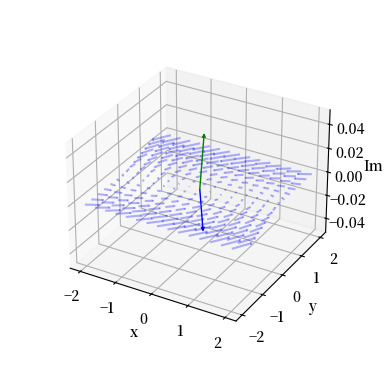

In [30]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d,
                                           self.axes.M)
        self.set_positions((0.1*xs[0], 0.1*ys[0]),
                           (0.1*xs[1], 0.1*ys[1]))

        return np.min(zs)


eigenvalues, eigenvectors = np.linalg.eig(A)

#为向量场创建网格
x, y = np.meshgrid(np.linspace(-2, 2, 15),
                   np.linspace(-2, 2, 15))

# 计算向量场（实部和虚部）
u_real = A[0][0] * x + A[0][1] * y
v_real = A[1][0] * x + A[1][1] * y
u_imag = np.zeros_like(x)
v_imag = np.zeros_like(y)

# 创建3D图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
vlength = np.linalg.norm(eigenvectors)
ax.quiver(x, y, u_imag, u_real-x, v_real-y, v_imag-u_imag,
          colors='b', alpha=0.3, length=.2,
          arrow_length_ratio=0.01)

arrow_prop_dict = dict(mutation_scale=5,
                       arrowstyle='-|>', shrinkA=0, shrinkB=0)

# 绘制3D特征向量
for c, i in zip(['b', 'g'], [0, 1]):
    a = Arrow3D([0, eigenvectors[0][i].real],
                [0, eigenvectors[1][i].real],
                [0, eigenvectors[1][i].imag],
                color=c, **arrow_prop_dict)
    ax.add_artist(a)

# 设置坐标轴标签和标题
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Im')
ax.set_box_aspect(aspect=None, zoom=0.8)

plt.draw()
plt.show()

```{solution-end}
```